## CNN Model Performance

Import the two models imported from python jobs

1 is the standard model as defined in Module 8 (Human Activity Recognition) (input, output shapes changed)

2 has one less Conv1D layer

In [1]:
import pandas as pd
import numpy as np
import time
import os, psutil
import pickle
#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
def printmem():
    process = psutil.Process(os.getpid())
    print("   memory:",round(process.memory_info().rss/(10**9),3),'Gbytes')  # in bytes 
    
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tabulate import tabulate
from tensorflow import keras
from keras.models import load_model

2024-12-12 19:17:12.557764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 19:17:13.231950: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 19:17:13.239514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-12 19:17:13.239531: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
def calc_performance_CNN(y_vals_true, y_vals_pred, labels, label_names={}, max_letters_label=-1):
#
# Get the numbers for the confusion matrix
# To get output: cf_matrix[true_label,pred_label]
    cf_matrix = confusion_matrix(y_vals_true, y_vals_pred, labels=labels)
#
# This is a graphic
    cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=labels)
#
# Make the header row
    header = [""]
    for column_name in labels:
        header.append('Pred:' + str(column_name))
    table = [header]
#
# Now make the rows with the matrix
    for row_name in labels:
        row_label = row_name
        if row_name in label_names:
            row_label = label_names[row_name]
            if max_letters_label > 0:
                row_label = row_label[:max_letters_label]
        row = ['True:'+str(row_label)]
        for column_name in labels:
            row_index = labels.index(row_name)
            column_index = labels.index(column_name)
            row.append(cf_matrix[row_index,column_index])
        table.append(row)
    # table = [
    #     [ "", "Predicted Class 1", "Precicted Class 0"],
    #     [ "True Class 1", TP, FN ],
    #     [ "True Class 0", FP, TN ]
    # ]
    print_table_type='fancy_grid'
    print_table = tabulate(table, headers='firstrow', tablefmt=print_table_type)
#    print(print_table)
#
# Get the recall, precision, ands F1 for each individual label
# - return both the "string report" (which you can print)
# - and the "dictionary report" (which you can use for averages and so on)
    report = classification_report(y_vals_true,y_vals_pred)
    report_dict = classification_report(y_vals_true,y_vals_pred,output_dict=True)
#
    results = {"confusionMatrix":cf_matrix,
                    'confusion_matrix_display':cf_disp,
                    'confusion_matrix_print_table':print_table,      
                    "report":report,"report_dict":report_dict}
    return results

def calc_performance_keras(network,input_features,true_labels,output_classes,label_names={}): #true_labels_cat,
#
# Get the overall performance for the test sample
    loss, accuracy = network.evaluate(input_features,true_labels)     #_cat
#
# Get the individual predictions for each sample in the test set
    predictions = network.predict(input_features)
#
# Get the max probabilites for each rows
    predicted_probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
    predicted_labels = np.argmax(predictions, axis = 1)
#
# Now call calc_performance_multi
    results = calc_performance_CNN(true_labels, predicted_labels,output_classes,label_names)
#
# Add the overall loss and accuracy
    results['loss'] = loss
    results['accuracy'] = accuracy
#
    return results

In [2]:
dfTrain = pd.read_csv('train_Normal.zip')

In [3]:
dfTrain.head()

,AGE,SEX,E_0,E_1,E_10,E_100,E_101,E_102,E_103,E_104,...,E_98,E_99,E_132,E_134,E_136,E_56,E_58,E_59,severity,pathoClass
0,18,0,0,0,0,0,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.4,0.3,0.3,4,0
1,21,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.6,0.0,0.7,0.7,0.2,2,1
2,19,1,0,0,0,0,0,0,0,0,...,0,0,0.4,0.0,0.0,0.5,0.2,0.6,2,2
3,34,1,0,0,0,0,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.7,0.5,0.4,4,0
4,36,0,0,0,0,0,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.5,0.4,0.2,4,0


In [4]:
X = dfTrain.iloc[:, 0:-2].to_numpy()
y = dfTrain['severity'].values
labels = [0,1,2,3,4]
severity_map = {0:'Most',
          1:'More',
          2:'Intermediate',
          3:'Less',
          4:'Least'}
num_classes = len(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [5]:
cnn_network_1 = load_model('model/model_cnn_AnotherOne.h5')
cnn_network_2 = load_model('model/model_cnn_NoOverwritePls.h5')

2024-12-12 02:27:19.291854: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-12 02:27:19.291933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-rx1ap78l): /proc/driver/nvidia/version does not exist
2024-12-12 02:27:19.292750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
results_train1 = calc_performance_keras(cnn_network_1, X_train, y_train, labels, severity_map)

25641/25641 [==============================] - 224s 9ms/step


In [7]:
results_train2 = calc_performance_keras(cnn_network_2, X_train, y_train, labels, severity_map)
results_test1 = calc_performance_keras(cnn_network_1, X_test, y_test, labels, severity_map)
results_test2 = calc_performance_keras(cnn_network_2, X_test, y_test, labels, severity_map)

6411/6411 [==============================] - 51s 8ms/step


In [18]:
list(results_train2['confusionMatrix'][0]).append(list(results_test2['confusionMatrix'][0]))

In [21]:
results_train2['confusionMatrix']

array([[ 63512,     24,     14,      2,      1],
       [     5, 166494,     20,     65,      0],
       [     0,    139, 247117,     66,     10],
       [     0,    123,     24, 252753,   1870],
       [     0,      0,     14,     85,  88143]])

In [23]:
[np.union1d(row1,row2) for row1, row2 in zip(results_train2['confusionMatrix'], results_test2['confusionMatrix'])]

[array([    0,     1,     2,     4,    12,    14,    24, 16142, 63512]),
 array([     0,      3,      4,      5,     20,     65,  41637, 166494]),
 array([     0,      3,     10,     21,     66,    139,  61933, 247117]),
 array([     0,      7,     24,     28,    123,    463,   1870,  63098,
        252753]),
 array([    0,     3,    14,    18,    85, 21703, 88143])]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)

In [16]:
result_name = ["results_train1", "results_test1", "results_train2", "results_test2"]
results = [results_train1, results_test1, results_train2, results_test2]
for i in range(0,4):
    print(result_name[i])
    j = results[i]
    print(j['confusion_matrix_print_table'])
    print('Loss:', j['loss'], 'Accuracy:', j['accuracy'])
    print()

results_train1
╒═══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│                   │   Pred:0 │   Pred:1 │   Pred:2 │   Pred:3 │   Pred:4 │
╞═══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ True:Most         │    63531 │       21 │        1 │        0 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:More         │        0 │   166581 │        3 │        0 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Intermediate │        1 │       31 │   247287 │       11 │        2 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Less         │        0 │       15 │        1 │   252995 │     1759 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Least        │        0 │        0 │        1 │       19 │    88222 │
╘═══════════════════╧══════════╧══════════╧══════════╧═══════

In [17]:
len(X_train)

820481

## Time
Comparing confusion matrices and loss/accuracy, the model having one less concolutional layer is perofrming a little worse. But how much time did it save to remove that layer? (CNN time is the time from initially defining the sequential model to finsihing the fitting of the model to the training data of abour 820,000 patients.)

Model 1:
- CNN time: 10414.826335191727 (~2h 53min)
- Best validation accuracy is: 0.997650146484375
- Number of iterations: 20

Model 2 (1 layer removed):
- CNN time: 6429.10711479187 (~1h 47min)
- Best validation accuracy is: 0.9970359206199646
- Number of iterations: 14

The second model takes almost an entire hour less to achieve only a slightly lower accuracy/higher loss. I would say this is significantly more ressourceful and for the purpose of my project, the second model is more than sufficient (significantly better than the random forest).

results_train1
results_test1
results_train2
results_test2


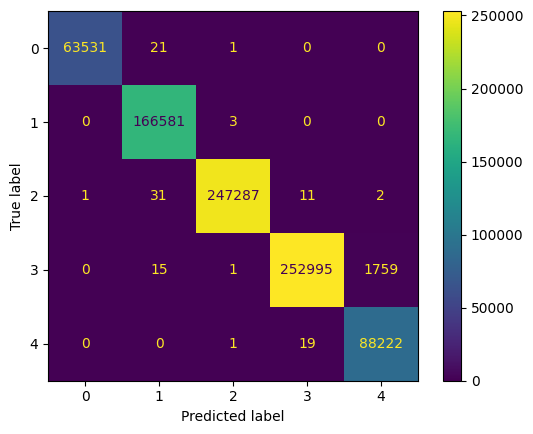

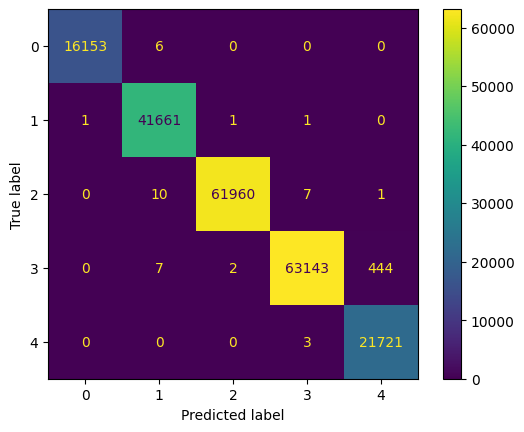

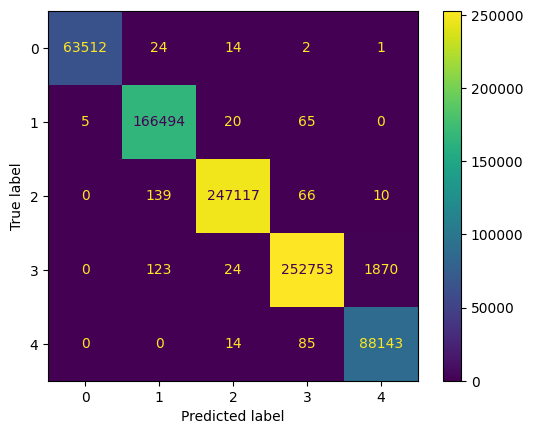

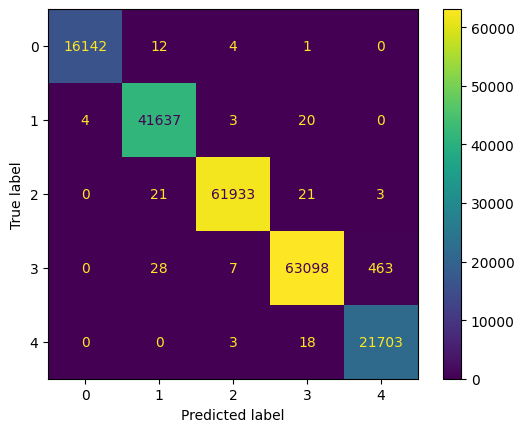

In [18]:
result_name = ["results_train1", "results_test1", "results_train2", "results_test2"]
results = [results_train1, results_test1, results_train2, results_test2]
for i in range(0,4):
    print(result_name[i])
    j = results[i]
    fileName = 'output/'+result_name[i]+'.png'
    j['confusion_matrix_display'].plot()
    plt.savefig(fileName)